In [97]:
import numpy as np
import tensorflow as tf

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.13.1
Found GPU at: 


In [98]:
from pathlib import Path
base_dir = Path('/home/mattia/Desktop/MLexercises/homework/homework2/train')

folders = [base_dir / str(i) for i in range(5)]
#print(folders)

In [99]:
#Create the dataset with the images
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(96, 96)
)

base_dir = Path('/home/mattia/Desktop/MLexercises/homework/homework2/test')

folders2 = [base_dir / str(i) for i in range(5)]

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(96, 96)
)

Found 6369 files belonging to 5 classes.
Found 2749 files belonging to 5 classes.


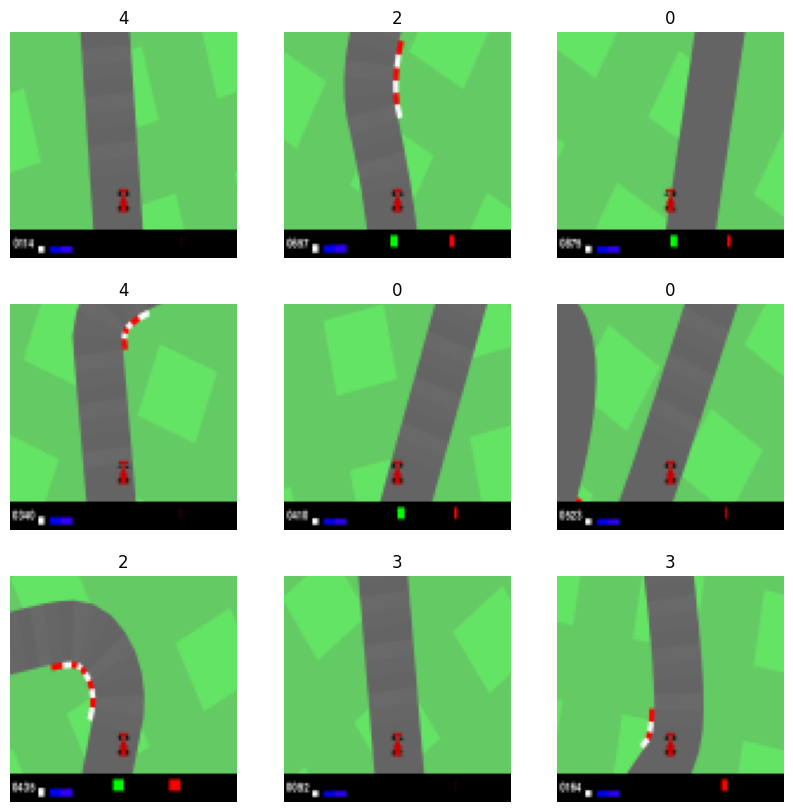

In [100]:
import matplotlib.pyplot as plt

#plot some images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [101]:
#print the shape of the images
for images, labels in train_dataset: #RICORDA: cicli su batch
    print(images[0].shape)
    print(labels[0])
    print(images[0].dtype)
    break

(96, 96, 3)
tf.Tensor(0, shape=(), dtype=int32)
<dtype: 'float32'>


In [102]:
from tensorflow.keras import layers
#normalize input to [0,1]
#for images, labels in train_dataset: 
#    images = tf.image.per_image_standardization(images)

#data augmentation
data_augmentation = tf.keras.Sequential([
    #Adding a random flip
    layers.RandomFlip("horizontal_and_vertical"),
    #Random Rotation
    layers.RandomRotation(0.2),
    #Random zoom
    layers.RandomZoom(0.2, 0.2),
    #Change the brightness
    layers.RandomBrightness(0.2),
    #Change the contrast
    layers.RandomContrast(0.2),
    #Add some translation factor
    layers.RandomTranslation(0.1, 0.1)
])

In [103]:
#CREATE THE MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import regularizers, optimizers

def carNet(input_shape, num_classes):
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same', dilation_rate = 2),
        MaxPooling2D(pool_size=(2, 2)),
        #BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', dilation_rate = 2),
        MaxPooling2D(pool_size=(2, 2)),
        #BatchNormalization(),
        #Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', dilation_rate = 2),
        #MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [104]:
#Instantiate the model
input_shape = (96, 96, 3)
model = carNet(input_shape, num_classes=5)
model.build(input_shape=(None, *input_shape))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_30 (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 rescaling_16 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                               

In [105]:
from keras.src.utils.version_utils import callbacks
from keras.src.callbacks import EarlyStopping

#Training the model
#reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = carNet(input_shape, num_classes=5)
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
200/200 [==============================] - 51s 251ms/step - loss: 1.5503 - accuracy: 0.3125 - val_loss: 1.3553 - val_accuracy: 0.6548
Epoch 2/20
200/200 [==============================] - 49s 246ms/step - loss: 1.4795 - accuracy: 0.3734 - val_loss: 1.1798 - val_accuracy: 0.6388
Epoch 3/20
200/200 [==============================] - 49s 243ms/step - loss: 1.4460 - accuracy: 0.3899 - val_loss: 1.2085 - val_accuracy: 0.6133
Epoch 4/20
200/200 [==============================] - 48s 242ms/step - loss: 1.4360 - accuracy: 0.4034 - val_loss: 1.0892 - val_accuracy: 0.6464
Epoch 5/20
200/200 [==============================] - 48s 242ms/step - loss: 1.4242 - accuracy: 0.4109 - val_loss: 1.1550 - val_accuracy: 0.6297
Epoch 6/20
200/200 [==============================] - 48s 242ms/step - loss: 1.4134 - accuracy: 0.4165 - val_loss: 1.0262 - val_accuracy: 0.6537
Epoch 7/20
200/200 [==============================] - 49s 243ms/step - loss: 1.4016 - accuracy: 0.4274 - val_loss: 1.2354 - val_ac

In [106]:
#Save the model
model.save("Modello1.keras")